### Задание 3. Python

**3.1 Задача**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.
  

In [93]:
import pandas as pd
import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt



In [165]:
path = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'

In [166]:
def def_groups_adding(path):


    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key = path))
    request_url = requests.get(url)                   # запрос на извлечение данных
    download_url = request_url.json()['href']         # json файл
    download_response = requests.get(download_url)    
    with open('groups_add.csv', 'wb') as f:
        f.write(download_response.content)            #открытие на запись, в двоичном режиме


    #читаем таблицы

    groups = pd.read_csv('groups.csv', sep=';')
    groups_add = pd.read_csv('groups_add.csv', sep=',')
    active_studs = pd.read_csv('active_studs.csv', sep=',')
    checks = pd.read_csv('checks.csv', sep=';')


    # Проводим проверку и соединение таблиц groups и groups_add

    if groups.shape[1] == groups_add.shape[1]:
        if (all(groups_add.iloc[:, [1]].dtypes == object) and all(groups_add.iloc[:, [0]].dtypes == 'int64')):
                users = groups.append(groups_add)
                print('Добавление прошло успешно')
        else:
            print('Ошибка добавения')
    else:
        print('Ошибка добавения')        


    # для отображения активности по действию, добавим колонку с единицей
    active_studs['active'] = 1
    checks['payment'] = 1

    # Проводим мердж по всем таблицам

    df_full = users.merge(active_studs, how='left',left_on='id', right_on='student_id').fillna(0)
    df_full = df_full.merge(checks, how='left',left_on='id', right_on='student_id').fillna(0)
    df_full = df_full[['id', 'grp', 'active', 'rev',  'payment']] #оставляем нужные колонки


    # Фильруем пользователей, которые зашли на платформу в дни проведения эксперимента
    active_users = df_full.query('active == 1')    

    # ARPPU - Средний доход на платящего пользователя

    ARPPU_A = round(active_users.query('grp == "A" and payment == 1').rev.sum()\
                 / active_users.query('grp == "A"  and payment == 1').id.count(), 2)

    ARPPU_B = round(active_users.query('grp == "B" and payment == 1').rev.sum()\
                 / active_users.query('grp == "B"  and payment == 1').id.count(), 2)
    # ARPU - Cредний доход с привлечённого пользователя.

    ARPU_A = round(active_users.query('grp == "A" and payment == 1').rev.sum()\
                 / active_users.query('grp == "A"').id.count(), 2)

    ARPU_B = round(active_users.query('grp == "B" and payment == 1').rev.sum()\
                 / active_users.query('grp == "B"').id.count(), 2)




    # CR в покупку A
    CR_A = round(100 * active_users.query('grp == "A" and payment == 1').count().id / active_users.query('grp == "A"').count().id, 2)

    # CR в покупку B
    CR_B = round(100 * active_users.query('grp == "B" and payment == 1').count().id / active_users.query('grp == "B"').count().id, 2)

    #СR активного пользователя в покупку A
    CR_active_A = round(100 * active_users.query('grp == "A"').count().id / df_full.query('grp == "A"').count().id, 2)

    #СR активного пользователя в покупку B
    CR_active_B = round(100 * active_users.query('grp == "B"').count().id / df_full.query('grp == "B"').count().id, 2)


    full_metrics = pd.DataFrame({'grp' : ['A', 'B'], 'ARPU' : [ARPU_A, ARPU_B], 'ARPPU' : [ARPPU_A, ARPPU_B], 'CR' : [CR_A, CR_B], 'CR_active' : [CR_active_A, CR_active_B]})


    return full_metrics


        

In [167]:
def_groups_adding(path)

Добавление прошло успешно


,grp,ARPU,ARPPU,CR,CR_active
0,A,47.35,933.59,5.07,10.47
1,B,58.06,1257.88,4.62,11.36


In [213]:
df_plot = def_groups_adding(path)

Добавление прошло успешно


In [215]:
def bar_metrics(df_plot):

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
    sns.barplot(x=df_plot.grp, y=df_plot.ARPU, ax=ax[0][0], data=df_plot, palette="mako", alpha=0.5).set(xlabel='GROUPS', ylabel='ARPU', title='ARPU')
    sns.barplot(x=df_plot.grp, y=df_plot.ARPPU, ax=ax[0][1], data=df_plot, palette="mako", alpha=0.5).set(xlabel='GROUPS', ylabel='ARPPU', title='ARPPU' )
    sns.barplot(x=df_plot.grp, y=df_plot.CR, ax=ax[1][0], data=df_plot, palette="mako").set(xlabel='GROUPS', ylabel='CR', title='CR' )
    sns.barplot(x=df_plot.grp, y=df_plot.CR_active, ax=ax[1][1], data=df_plot, palette="mako").set(xlabel='GROUPS', ylabel='CR_active', title='CR_active' )
    sns.despine()  # убрать часть рамки графика


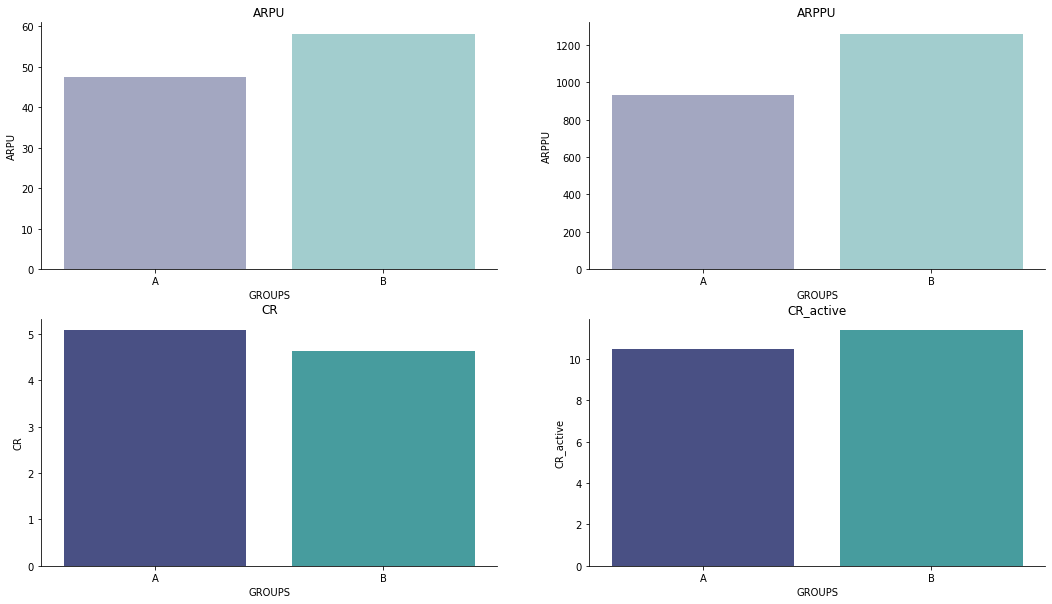

In [216]:
bar_metrics(df_plot)